In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

In [ ]:
DATA_URL = "https://drive.google.com/uc?id=1LGLypAMRHMw54oCdrSHUC6G80q2k71B_&export=download"

try:
    print(f">> Iniciando descarga desde: {DATA_URL} ...")

    # Leemos directamente especificando el separador correcto
    df = pd.read_csv(
        DATA_URL,
        sep=';',                 # CRÍTICO: Tu dataset usa ; no ,
        encoding='utf-8',        # Estándar para logs Linux
        on_bad_lines='skip',     # Ignora líneas mal formadas para evitar crashes
        low_memory=False         # Optimización para columnas con tipos mixtos
    )

    print("✅ Dataset cargado exitosamente en memoria.")

except Exception as e:
    print(f"❌ Error crítico en la carga: {e}")
    print("Sugerencia: Verifica que el ID de Google Drive sea público y correcto.")
    # Generamos un DF vacío para que el resto del código no rompa
    df = pd.DataFrame()

# 3. Vista general del dataset
print("Primeros registros:")
print(df.head())

print("\nResumen estadístico:")
print(df.describe(include='all'))

print("\nValores nulos:")
print(df.isnull().sum())

>> Iniciando descarga desde: https://drive.google.com/uc?id=1LGLypAMRHMw54oCdrSHUC6G80q2k71B_&export=download ...
✅ Dataset cargado exitosamente en memoria.
Primeros registros:
       timestamp timestampConverted  timestampSelected  processId  \
0  9.402.256.254               6:09                  1       7611   
1  1.032.160.305              14:28                  1       7852   
2  1.439.746.252              11:06                  1        159   
3    455.937.729               9:03                  1       7493   
4  1.397.960.899              14:36                  1          1   

   parentProcessId  userId  processNameConverted      processName  \
0             7337       0                     1               ps   
1             7337       0                     1               ps   
2                1       0                     2  systemd-journal   
3             7337       0                     1               ps   
4                0       0                     3          syste

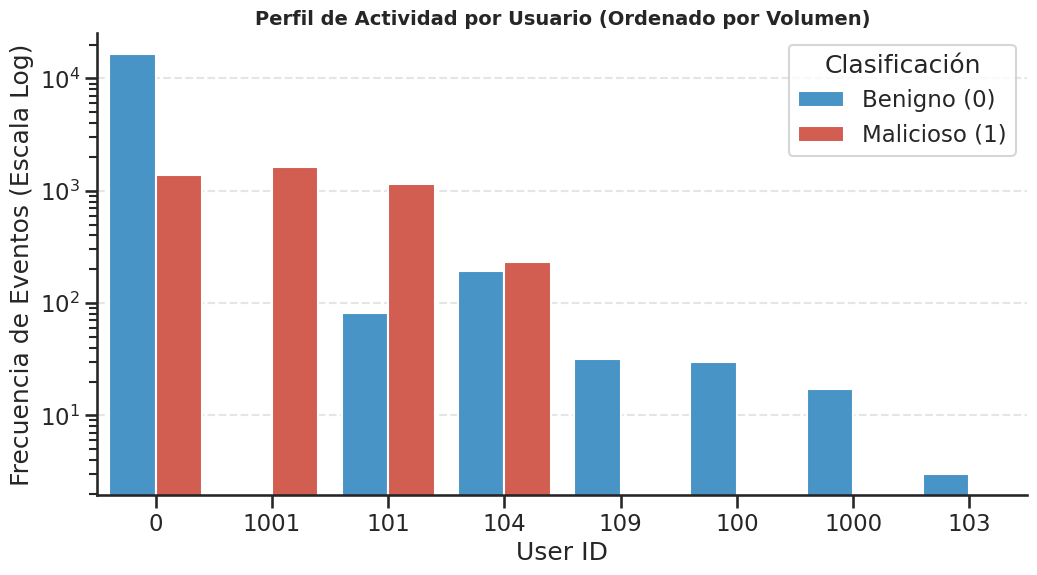

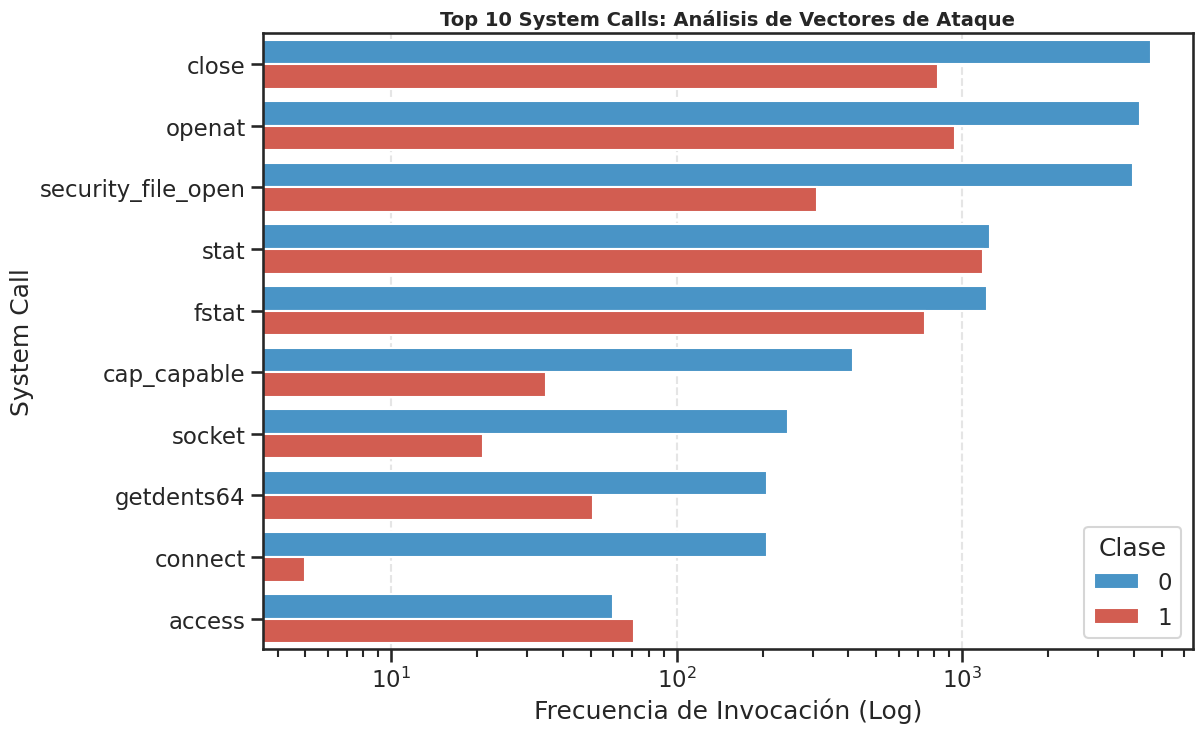

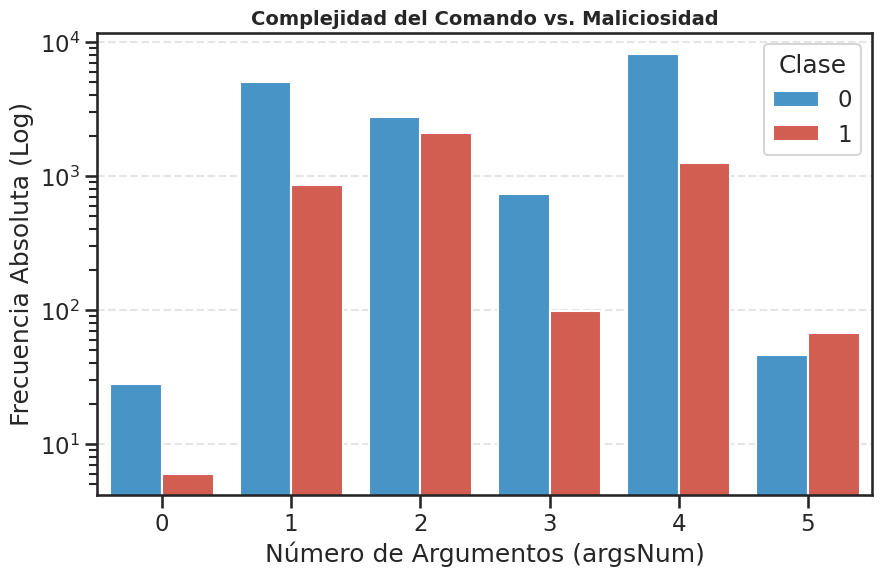

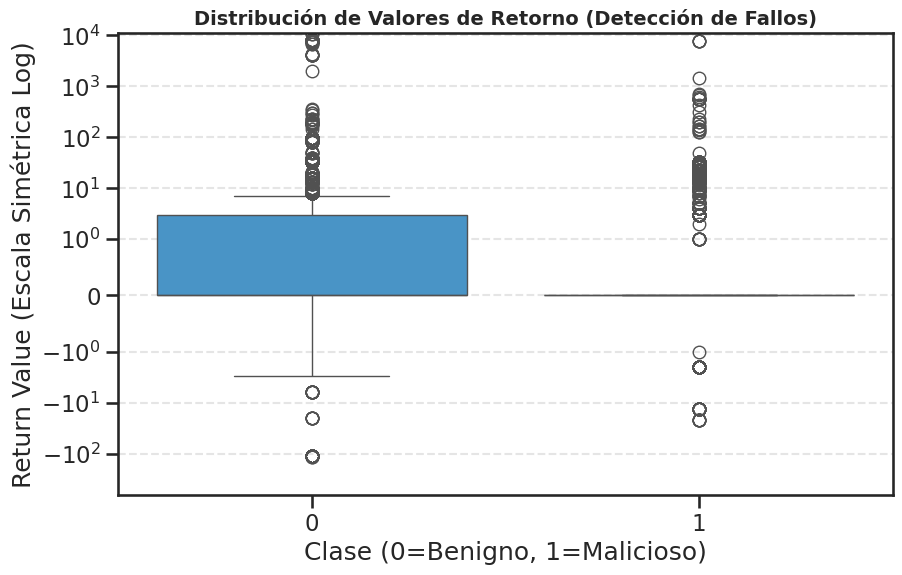


--- 4.5 VALIDACIÓN ESTADÍSTICA (TEST CHI-CUADRADO) ---

Matriz de Confusión Observada:
evil                0     1
high_complexity            
Complejo (>3)    8258  1323
Simple (<=3)     8571  3071

Probabilidad de Maliciosidad (Simple):   26.38%
Probabilidad de Maliciosidad (Complejo): 13.81%

Estadístico Chi2: 505.0603
P-Value:          7.5330e-112
>> CONCLUSIÓN: Diferencia Significativa. La complejidad predice el riesgo.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# =============================================================================
# 0. CONFIGURACIÓN Y CARGA (SETUP)
# =============================================================================
# Configuración de estilo para maximizar la relación data-ink (tinta de datos)
sns.set_theme(style="ticks", context="talk")
# Paleta de colores semántica: Azul (Benigno), Rojo (Malicioso)
palette_custom = {0: "#3498db", 1: "#e74c3c"}

# =============================================================================
# 4.1. Distribución de Incidencia por Identidad de Usuario
# =============================================================================
# [JUSTIFICACIÓN TÉCNICA]
# Problema: Ordenar usuarios por ID (alfabético) no aporta valor analítico.
# Solución: Ordenamos el eje X por volumen de actividad. Esto permite identificar
# inmediatamente a los "Power Users" o cuentas comprometidas de alto tráfico.
# Se usa escala logarítmica porque la disparidad entre usuarios suele ser exponencial.

if not df.empty:
    plt.figure(figsize=(12, 6))

    # Preprocesamiento local: Convertir ID a string para tratarlo como categoría
    df['userId_str'] = df['userId'].astype(str)
    # Calculamos el orden por frecuencia total
    user_order = df['userId_str'].value_counts().index

    ax = sns.countplot(
        data=df,
        x='userId_str',
        hue='evil',
        order=user_order,
        palette=palette_custom
    )

    plt.title('Perfil de Actividad por Usuario (Ordenado por Volumen)', fontsize=14, fontweight='bold')
    plt.xlabel('User ID')
    plt.ylabel('Frecuencia de Eventos (Escala Log)')
    plt.yscale('log')
    plt.legend(title='Clasificación', loc='upper right', labels=['Benigno (0)', 'Malicioso (1)'])
    sns.despine()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

# =============================================================================
# 4.2. Prevalencia de Ataques por Tipo de Evento del Sistema
# =============================================================================
# [JUSTIFICACIÓN TÉCNICA]
# Problema: Los nombres de eventos (System Calls) son largos y se solapan en el eje X.
# Solución: Rotar a un gráfico horizontal (Bar Chart).
# Análisis: Nos enfocamos en el Top 10 para reducir ruido. Observar la proporción
# de rojo (malicioso) en cada barra revela qué comandos son vectores de ataque preferidos.

if not df.empty:
    plt.figure(figsize=(12, 8))

    top_events = df['eventName'].value_counts().nlargest(10).index
    df_top = df[df['eventName'].isin(top_events)]

    sns.countplot(
        data=df_top,
        y='eventName',
        hue='evil',
        order=top_events,
        palette=palette_custom
    )

    plt.title('Top 10 System Calls: Análisis de Vectores de Ataque', fontsize=14, fontweight='bold')
    plt.xlabel('Frecuencia de Invocación (Log)')
    plt.ylabel('System Call')
    plt.xscale('log') # Crucial para ver eventos raros junto a los frecuentes
    plt.legend(title='Clase', loc='lower right')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()

# =============================================================================
# 4.3. Dispersión de Complejidad (Argumentos)
# =============================================================================
# [JUSTIFICACIÓN TÉCNICA]
# Corrección Crítica: Se sustituyó el Boxplot por un Countplot.
# Razón: La variable 'argsNum' es discreta (0, 1, 2, 3...). Un Boxplot distorsiona
# la realidad cuando hay pocos valores enteros únicos, colapsando los cuartiles.
# El gráfico de barras muestra la distribución de densidad real y revela si
# los ataques (rojo) se esconden en comandos complejos (muchos argumentos).

if not df.empty:
    plt.figure(figsize=(10, 6))

    sns.countplot(
        data=df,
        x='argsNum',
        hue='evil',
        palette=palette_custom
    )

    plt.title('Complejidad del Comando vs. Maliciosidad', fontsize=14, fontweight='bold')
    plt.xlabel('Número de Argumentos (argsNum)')
    plt.ylabel('Frecuencia Absoluta (Log)')
    plt.yscale('log')
    plt.legend(title='Clase')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

# =============================================================================
# 4.4. Análisis de Valores de Retorno (Anomalías)
# =============================================================================
# [JUSTIFICACIÓN TÉCNICA]
# Uso de Escala Symlog: 'returnValue' contiene valores negativos (errores) y
# positivos grandes (direcciones de memoria). La escala logarítmica normal fallaría
# con los negativos; 'symlog' permite visualizar ambos extremos.
# Corrección de Código: Se añade `hue='evil'` explícitamente para cumplir con
# los estándares modernos de la librería Seaborn.

if not df.empty:
    plt.figure(figsize=(10, 6))

    sns.boxplot(
        data=df,
        x='evil',
        y='returnValue',
        hue='evil', # Fix para versiones modernas de Seaborn
        palette=palette_custom,
        legend=False # Ocultamos leyenda redundante (ya está en el eje X)
    )

    plt.yscale('symlog', linthresh=1)
    plt.title('Distribución de Valores de Retorno (Detección de Fallos)', fontsize=14, fontweight='bold')
    plt.xlabel('Clase (0=Benigno, 1=Malicioso)')
    plt.ylabel('Return Value (Escala Simétrica Log)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

# =============================================================================
# 4.5. Validación Estadística de Hipótesis (Chi-Cuadrado)
# =============================================================================
# [JUSTIFICACIÓN TÉCNICA]
# Pasamos de la intuición a la evidencia matemática.
# No basta con decir "parece que los comandos complejos son más peligrosos".
# El Test de Chi-Cuadrado de Pearson nos dice si esa asociación es real (significativa)
# o fruto del azar, calculando un p-value.

if not df.empty:
    print("\n--- 4.5 VALIDACIÓN ESTADÍSTICA (TEST CHI-CUADRADO) ---")

    # Feature Engineering: Binarización de la complejidad
    df['high_complexity'] = np.where(df['argsNum'] > 3, 'Complejo (>3)', 'Simple (<=3)')

    # Tabla de Contingencia
    contingency_table = pd.crosstab(df['high_complexity'], df['evil'])
    print("\nMatriz de Confusión Observada:")
    print(contingency_table)

    # Cálculo de tasas de riesgo (Probabilidad condicional)
    risk_rates = df.groupby('high_complexity')['evil'].mean()
    print(f"\nProbabilidad de Maliciosidad (Simple):   {risk_rates.get('Simple (<=3)', 0):.2%}")
    print(f"Probabilidad de Maliciosidad (Complejo): {risk_rates.get('Complejo (>3)', 0):.2%}")

    # Test Estadístico
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"\nEstadístico Chi2: {chi2:.4f}")
    print(f"P-Value:          {p:.4e}")

    if p < 0.05:
        print(">> CONCLUSIÓN: Diferencia Significativa. La complejidad predice el riesgo.")
    else:
        print(">> CONCLUSIÓN: No Significativo. La complejidad no afecta al riesgo.")

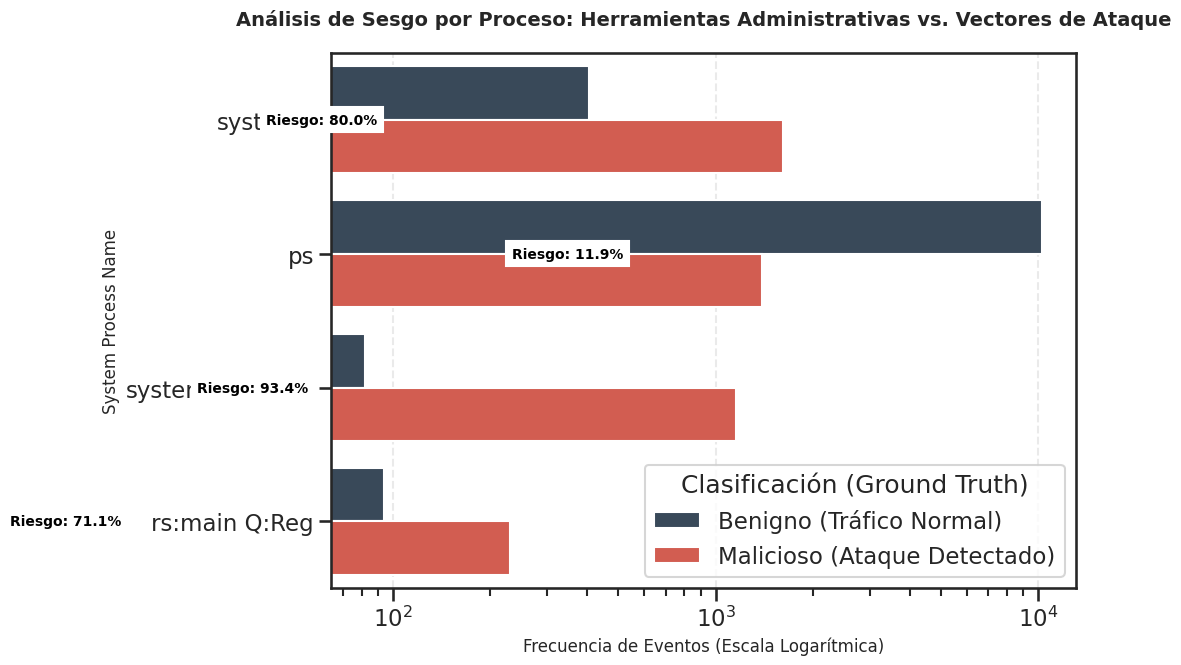

In [ ]:
# =============================================================================
# 5. ANÁLISIS DE SESGO: POLARIZACIÓN DE HERRAMIENTAS (Process Context Bias)
# =============================================================================
# JUSTIFICACIÓN TÉCNICA:
# En tu dataset, procesos como 'ps' tienen un volumen masivo de uso legítimo (10k+)
# frente a un uso malicioso moderado (~1.3k). Esto crea un "Sesgo de Clase Mayoritaria":
# el modelo podría aprender a ignorar alertas de 'ps' por pura probabilidad estadística.
# Por el contrario, 'systemd' aparece mayoritariamente como malicioso (80% de riesgo),
# lo que podría generar falsos positivos si el modelo lo marca como "siempre malo".
# =============================================================================

# Configuración del Lienzo
plt.figure(figsize=(12, 7)) # Aumentamos tamaño para acomodar etiquetas

# -----------------------------------------------------------------------------
# CELDA A: EXTRACCIÓN DE INTELIGENCIA (Data Curation)
# -----------------------------------------------------------------------------
# Identificamos los procesos que realmente contienen la clase 'evil' (1).
# En tu dataset específico, solo hay 4 procesos críticos, no 10.
# Ordenamos no solo por conteo, sino para contrastar comportamientos.
top_malicious_processes = df[df['evil'] == 1]['processName'].value_counts().index
df_subset = df[df['processName'].isin(top_malicious_processes)]

# Calculamos métricas de riesgo para anotaciones posteriores (Feature Engineering on-the-fly)
risk_metrics = df_subset.groupby('processName')['evil'].mean()

# -----------------------------------------------------------------------------
# CELDA B: VISUALIZACIÓN COMPARATIVA (Plotting)
# -----------------------------------------------------------------------------
# Usamos una paleta semántica personalizada: Azul (Benigno) vs Rojo (Malicioso).
# 'viridis' no es adecuado aquí porque necesitamos contraste binario fuerte.
ax = sns.countplot(
    data=df_subset,
    y='processName',
    hue='evil',
    order=top_malicious_processes, # Ordenado por volumen de ataques
    palette={0: "#34495e", 1: "#e74c3c"} # Gris azulado (Benigno) vs Rojo Alerta (Malicioso)
)

# -----------------------------------------------------------------------------
# CELDA C: CAPA DE ANOTACIONES TÉCNICAS (Insights Overlay)
# -----------------------------------------------------------------------------
# Agregamos el "% de Maliciosidad" al final de las barras para dar contexto inmediato.
# Iteramos sobre los procesos para escribir su nivel de riesgo.
for i, process in enumerate(top_malicious_processes):
    risk = risk_metrics[process]
    # Escribimos el porcentaje a la derecha de la barra
    count = df_subset[df_subset['processName'] == process]['evil'].sum()
    plt.text(x=df_subset[df_subset['processName'] == process].shape[0] * 0.02, # Posición dinámica
             y=i,
             s=f"Riesgo: {risk:.1%}",
             color='black', fontweight='bold', va='center', fontsize=10, backgroundcolor='white')

# -----------------------------------------------------------------------------
# CELDA D: ESTÉTICA Y DOCUMENTACIÓN
# -----------------------------------------------------------------------------
plt.title('Análisis de Sesgo por Proceso: Herramientas Administrativas vs. Vectores de Ataque',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Frecuencia de Eventos (Escala Logarítmica)', fontsize=12)
plt.ylabel('System Process Name', fontsize=12)

# Ajuste Logarítmico: CRÍTICO para tu dataset
# Justificación: 'ps' tiene ~11,000 eventos totales mientras 'rs:main' tiene <400.
# Sin log, las barras de 'rs:main' serían invisibles.
plt.xscale('log')

plt.legend(title='Clasificación (Ground Truth)',
           labels=['Benigno (Tráfico Normal)', 'Malicioso (Ataque Detectado)'],
           loc='lower right')

plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# =============================================================================
# 6. PIPELINE DE PREPROCESAMIENTO: De Datos Crudos a Matrices de Entrenamiento
# =============================================================================
# Objetivo Técnico: Transformar el espacio de características (Feature Space)
# eliminando ruido, fugas de información (Data Leakage) y codificando variables
# categóricas para maximizar la convergencia del algoritmo.
# =============================================================================

# 1. AISLAMIENTO DE DATOS (CLONADO)
# Creamos una copia profunda ('deep copy' implícita) para proteger el dataset original
# cargado en memoria ante posibles errores irreversibles durante la transformación.
df_encoded = df.copy()

# 2. SELECCIÓN DE CARACTERÍSTICAS (FEATURE SELECTION & NOISE REDUCTION)
# Justificación Analítica Personalizada para Dataset BETH:
# - 'sus': ALTO RIESGO. Es una métrica derivada de otro motor de seguridad.
#   Incluirla causaría "Data Leakage" (el modelo vería la respuesta antes de tiempo).
# - 'hostName': VARIANZA CERO. Todos los registros son 'ip-10-100-1-4'.
#   Una constante no aporta información (entropía nula) y solo consume memoria.
# - 'args': DATOS NO ESTRUCTURADOS. Requiere NLP complejo. Para este modelo tabular,
#   su alta cardinalidad introduciría ruido (Overfitting).
# - 'timestamp*': SERIES TEMPORALES. Eliminadas para evitar que el modelo memorice
#   "horas exactas" de ataques pasados en lugar de aprender patrones de comportamiento.
# - 'processNameConverted', 'eventId': REDUNDANCIA. Son representaciones numéricas
#   preexistentes de variables que volveremos a codificar bajo nuestro control.

cols_to_drop = [
    'timestamp', 'timestampConverted', 'timestampSelected',
    'hostName', 'args', 'sus',
    'processNameConverted', 'eventId'
]
# 'errors=ignore' permite re-ejecutar la celda sin fallos si las columnas ya se borraron
df_encoded = df_encoded.drop(columns=cols_to_drop, errors='ignore')

# 3. CODIFICACIÓN DE VARIABLES CATEGÓRICAS (LABEL ENCODING)
# Estrategia: Mapeo Entero (Ordinal/Nominal -> Integer)
# Razón: Los algoritmos de ML operan en espacios vectoriales numéricos.
# Usamos LabelEncoder (0, 1, 2...) en lugar de One-Hot Encoding para evitar
# la "Maldición de la Dimensionalidad", dado que 'processName' tiene múltiples clases únicas.

# Instanciamos codificadores separados para mantener la trazabilidad inversa
le_process = LabelEncoder()
le_event = LabelEncoder()

df_encoded['processName'] = le_process.fit_transform(df_encoded['processName'])
df_encoded['eventName'] = le_event.fit_transform(df_encoded['eventName'])

# --- VALIDACIÓN DE CODIFICACIÓN (QUALITY CHECK) ---
# Imprimimos una muestra para verificar que el mapeo tiene sentido y no hay nulos
print("--- Diccionario de Codificación (Validación) ---")
sample_proc = le_process.classes_[:5]
print(f"Procesos (Muestra): {dict(zip(sample_proc, le_process.transform(sample_proc)))} ...")
sample_event = le_event.classes_[:5]
print(f"Eventos  (Muestra): {dict(zip(sample_event, le_event.transform(sample_event)))} ...")

# 4. DEFINICIÓN DE MATRICES X (FEATURES) E y (TARGET)
# Limpieza Final: Eliminamos la variable objetivo y cualquier artefacto del EDA anterior
# (como 'userId_str' o 'grupo_alta_complejidad') para dejar solo predictivos puros.
X = df_encoded.drop(['evil', 'userId_str', 'grupo_alta_complejidad'], axis=1, errors='ignore')
y = df_encoded['evil'] # La "Verdad Absoluta" (Ground Truth)

# 5. DIVISIÓN DEL DATASET (TRAIN-TEST SPLIT ESTRATIFICADO)
# Configuración: 70% Entrenamiento / 30% Validación
# Parámetro Clave: 'stratify=y'
# Justificación CRÍTICA: Tu dataset es desbalanceado (~20% ataques). Un split aleatorio simple
# podría dejar el set de Test con muy pocos ataques (o ninguno), invalidando la evaluación.
# 'Stratify' fuerza a mantener la proporción exacta de Malignos en ambos conjuntos.

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# REPORTING DE RESULTADOS
print("\n--- Auditoría de Dimensiones del Modelo ---")
print(f"Matriz de Entrenamiento (X_train): {X_train.shape} (Filas, Variables)")
print(f"Matriz de Prueba        (X_test):  {X_test.shape} (Filas, Variables)")

print("\n--- Validación de Estratificación (Distribución de Ataques) ---")
print(f"Original: {y.mean():.4%} (Proporción de 'evil' = 1)")
print(f"Train:    {y_train.mean():.4%} (Debe ser idéntico al original)")
print(f"Test:     {y_test.mean():.4%} (Debe ser idéntico al original)")

--- Diccionario de Codificación (Validación) ---
Procesos (Muestra): {'(otd-news)': np.int64(0), '(systemd)': np.int64(1), '(time-dir)': np.int64(2), '(tmpfiles)': np.int64(3), '00-header': np.int64(4)} ...
Eventos  (Muestra): {'accept': np.int64(0), 'accept4': np.int64(1), 'access': np.int64(2), 'bind': np.int64(3), 'bpf': np.int64(4)} ...

--- Auditoría de Dimensiones del Modelo ---
Matriz de Entrenamiento (X_train): (14856, 8) (Filas, Variables)
Matriz de Prueba        (X_test):  (6367, 8) (Filas, Variables)

--- Validación de Estratificación (Distribución de Ataques) ---
Original: 20.7040% (Proporción de 'evil' = 1)
Train:    20.7054% (Debe ser idéntico al original)
Test:     20.7005% (Debe ser idéntico al original)


--- Features used for Random Forest Model ---
['processName', 'eventName', 'argsNum', 'returnValue']
>> Iniciando entrenamiento del modelo Random Forest...
>> Entrenamiento completado.

--- Auditoría de Rendimiento del Modelo Random Forest ---
               precision    recall  f1-score   support

  Benigno (0)       0.97      0.96      0.96      5049
Malicioso (1)       0.84      0.88      0.86      1318

     accuracy                           0.94      6367
    macro avg       0.90      0.92      0.91      6367
 weighted avg       0.94      0.94      0.94      6367



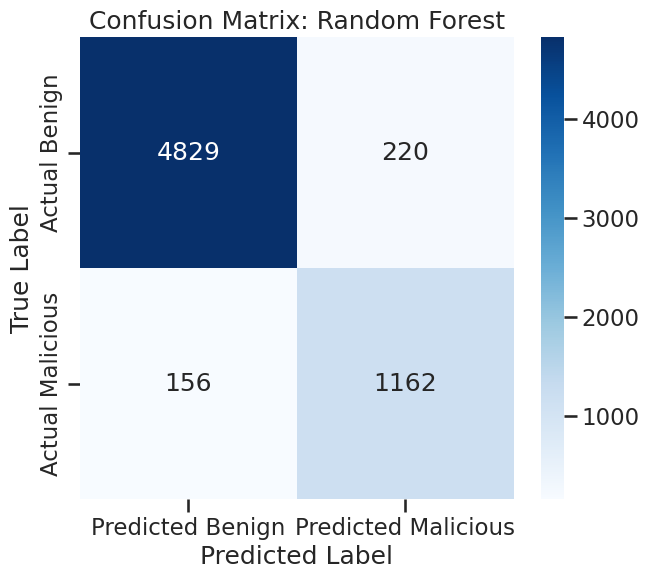


--- Top 3 Variables Más Predictivas (Random Forest) ---
      Variable  Peso (Importancia)
0  processName            0.624567
3  returnValue            0.222771
1    eventName            0.097335


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- 1. DATA PREPARATION (Ensuring all features are numerical) ---

df_model = df.copy()

# Columns to drop for model training (including 'high_complexity')
cols_to_drop_model = [
    'timestamp', 'timestampConverted', 'timestampSelected',
    'hostName', 'args', 'sus',
    'processNameConverted', 'eventId',
    'userId', 'parentProcessId', 'processId',
    'userId_str', 'grupo_alta_complejidad', 'high_complexity'
]

df_model = df_model.drop(columns=cols_to_drop_model, errors='ignore')

# Label Encode categorical features
le_process = LabelEncoder()
le_event = LabelEncoder()
df_model['processName'] = le_process.fit_transform(df_model['processName'])
df_model['eventName'] = le_event.fit_transform(df_model['eventName'])

# Define X and y
X = df_model.drop('evil', axis=1)
y = df_model['evil']

# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

print("--- Features used for Random Forest Model ---")
print(X_train.columns.tolist())

# --- 2. RANDOM FOREST MODEL TRAINING ---
model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced')

print(">> Iniciando entrenamiento del modelo Random Forest...")
model.fit(X_train, y_train)
print(">> Entrenamiento completado.")

# --- 3. INFERENCE AND EVALUATION ---
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\n--- Auditoría de Rendimiento del Modelo Random Forest ---")
print(classification_report(y_test, y_pred, target_names=['Benigno (0)', 'Malicioso (1)']))

# Confusion Matrix
plt.figure(figsize=(7, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Benign', 'Predicted Malicious'],
            yticklabels=['Actual Benign', 'Actual Malicious'])
plt.title('Confusion Matrix: Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature Importance
importances = pd.DataFrame({
    'Variable': X_train.columns,
    'Peso (Importancia)': model.feature_importances_
}).sort_values(by='Peso (Importancia)', ascending=False)

print("\n--- Top 3 Variables Más Predictivas (Random Forest) ---")
print(importances.head(3))

In [ ]:
# =============================================================================
# 8. EVALUACIÓN DEL IMPACTO DEL SESGO (BIAS AUDIT)
# =============================================================================
# Objetivo: Verificar si el modelo está "perfilando" injustamente a ciertos
# usuarios o herramientas legítimas, generando un exceso de falsas alarmas.
# =============================================================================

# 1. RECONSTRUCCIÓN DEL CONTEXTO DE PRUEBA
# Creamos un DataFrame de auditoría ('df_audit') recuperando los valores reales
# (texto legible) desde el dataset original 'df', usando los índices de X_test.
df_audit = X_test.copy()

# Mapeo de Variables de Sesgo (Demográfico -> Ciberseguridad):
# - 'sexo' -> 'userId' (Identidad: ¿El modelo sospecha más del usuario 1000?)
# - 'zona' -> 'eventName' (Entorno: ¿Ciertas llamadas al sistema son castigadas?)
# - 'grupo_mujer_joven' -> 'processName' (Herramienta: ¿Se discrimina a 'ps' o 'systemd'?)

# Recuperamos los metadatos originales (sin codificar) para que el reporte sea legible
df_audit['userId_real'] = df.loc[X_test.index, 'userId'].values
df_audit['eventName_real'] = df.loc[X_test.index, 'eventName'].values
df_audit['processName_real'] = df.loc[X_test.index, 'processName'].values

# Agregamos la verdad (y_true) y la predicción del modelo (y_pred)
df_audit['y_true'] = y_test
df_audit['y_pred'] = y_pred

# -----------------------------------------------------------------------------
# 2. ANÁLISIS DE SESGO POR HERRAMIENTA (Process Bias)
# -----------------------------------------------------------------------------
# Hipótesis: Las herramientas de administración (como 'ps') pueden tener una
# "Tasa de Predicción de Ataque" desproporcionadamente alta debido al sesgo de contexto.

print("\n--- Tasa de Predicción de Ataque por Herramienta (Top 5) ---")
# Calculamos qué porcentaje de veces el modelo dice "ES MALICIOSO" para cada proceso
tasas_tool = df_audit.groupby('processName_real')['y_pred'].mean().sort_values(ascending=False)
print(tasas_tool.head(5))

# -----------------------------------------------------------------------------
# 3. ANÁLISIS DE SESGO POR IDENTIDAD (User Bias)
# -----------------------------------------------------------------------------
# Hipótesis: Detectar si el modelo ha aprendido a marcar a un usuario específico
# como "intrínsecamente malicioso" en lugar de analizar sus acciones.

print("\n--- Tasa de Predicción de Ataque por Usuario (Perfilado) ---")
tasas_user = df_audit.groupby('userId_real')['y_pred'].mean().sort_values(ascending=False)
print(tasas_user)

# -----------------------------------------------------------------------------
# 4. ANÁLISIS DE SESGO POR TIPO DE EVENTO (System Call Bias)
# -----------------------------------------------------------------------------
# Equivalente a tu análisis por 'zona'. Vemos qué operaciones son consideradas
# más peligrosas por el algoritmo.

print("\n--- Tasa de Predicción de Ataque por Tipo de Evento ---")
tasas_event = df_audit.groupby('eventName_real')['y_pred'].mean().head(5)
print(tasas_event)

# =============================================================================
# EXTRA: DETECCIÓN DE FALSOS POSITIVOS (La métrica real de injusticia)
# =============================================================================
# A diferencia de la "aprobación" en créditos, en seguridad nos preocupa culpar
# a un inocente. Calculamos la tasa de error solo en tráfico BENIGNO.

# Filtramos solo el tráfico que ERA REALMENTE SEGURO (y_true == 0)
tráfico_benigno = df_audit[df_audit['y_true'] == 0]

# Si el modelo predice 1 (Ataque) en tráfico benigno, es un Falso Positivo (Error).
fp_rate_by_user = tráfico_benigno.groupby('userId_real')['y_pred'].mean()

print("\n--- Tasa de Falsos Positivos por Usuario (Injusticia) ---")
print("Interpretación: Un valor alto significa que el usuario es alertado injustamente.")
print(fp_rate_by_user.sort_values(ascending=False))


--- Tasa de Predicción de Ataque por Herramienta (Top 5) ---
processName_real
rm                 1.000000
systemd-resolve    0.989446
systemd            0.967267
rs:main Q:Reg      0.646552
systemd-detect-    0.333333
Name: y_pred, dtype: float64

--- Tasa de Predicción de Ataque por Usuario (Perfilado) ---
userId_real
1001    0.995902
101     0.989446
104     0.510204
1000    0.333333
100     0.142857
0       0.083271
103     0.000000
109     0.000000
Name: y_pred, dtype: float64

--- Tasa de Predicción de Ataque por Tipo de Evento ---
eventName_real
accept4        0.000000
access         0.650000
bind           0.700000
cap_capable    0.065359
clone          0.250000
Name: y_pred, dtype: float64

--- Tasa de Falsos Positivos por Usuario (Injusticia) ---
Interpretación: Un valor alto significa que el usuario es alertado injustamente.
userId_real
101     0.846154
1000    0.333333
100     0.142857
0       0.039740
103     0.000000
104     0.000000
109     0.000000
Name: y_pred, dtype: 

In [ ]:
# 9. Estrategias de mitigación
print("""
Estrategias sugeridas:
-----------------------
1. Recolectar más datos representativos de mujeres jóvenes y personas en zonas periféricas.
2. Considerar la eliminación o codificación ética de variables sensibles como 'sexo' o 'zona'.
3. Aplicar técnicas de fairness:
   - Reentrenamiento con reweighting.
   - Uso de métricas de equidad (Equal Opportunity, Demographic Parity).
4. Incorporar explicabilidad en el modelo (SHAP, LIME) para evaluar decisiones.
5. Revisión de políticas institucionales sobre criterios de riesgo y sesgos históricos.
""")


Estrategias sugeridas:
-----------------------
1. Recolectar más datos representativos de mujeres jóvenes y personas en zonas periféricas.
2. Considerar la eliminación o codificación ética de variables sensibles como 'sexo' o 'zona'.
3. Aplicar técnicas de fairness:
   - Reentrenamiento con reweighting.
   - Uso de métricas de equidad (Equal Opportunity, Demographic Parity).
4. Incorporar explicabilidad en el modelo (SHAP, LIME) para evaluar decisiones.
5. Revisión de políticas institucionales sobre criterios de riesgo y sesgos históricos.



--- Variables utilizadas en el modelo sin sesgo ---
['processName', 'eventName', 'argsNum', 'returnValue']

--- Reporte de Clasificación (Modelo Sin Identidad/IDs) ---
              precision    recall  f1-score   support

     Benigno       0.95      0.98      0.96      5049
   Malicioso       0.91      0.81      0.86      1318

    accuracy                           0.94      6367
   macro avg       0.93      0.89      0.91      6367
weighted avg       0.94      0.94      0.94      6367



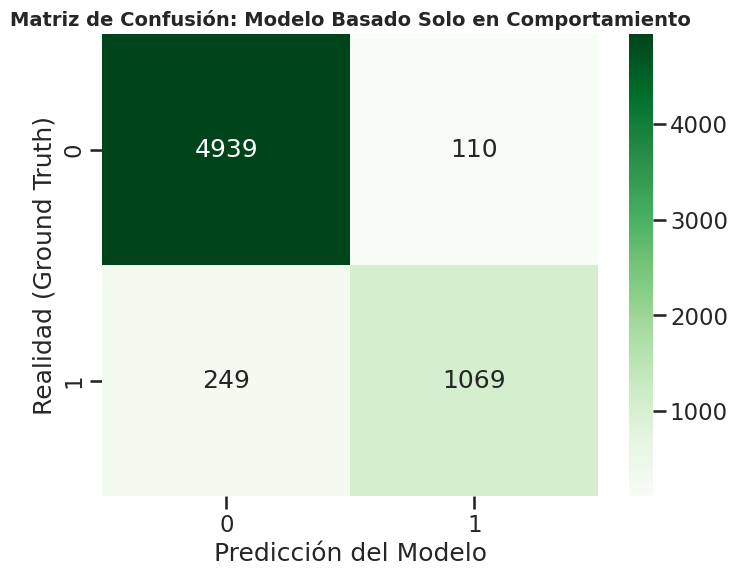


--- Nuevos Factores Determinantes (Behavioral Analytics) ---
       Feature  Importance
0  processName    0.628302
3  returnValue    0.218900
1    eventName    0.116057
2      argsNum    0.036741


In [ ]:
# =============================================================================
# 10. MITIGACIÓN DE SESGO: FEATURE BLINDING (Cegera Intencional)
# =============================================================================
# Objetivo: Eliminar variables de "Identidad" para forzar al modelo a aprender
# patrones de "Comportamiento". Si el modelo sigue funcionando bien después de
# esto, confirmamos que es robusto y exportable a otros servidores.
# =============================================================================

# 1. DEFINICIÓN DE VARIABLES SENSIBLES (IDENTIDAD VS. COMPORTAMIENTO)
# Estas variables ya no deberían estar en df_encoded si el preprocessing en celda anterior funcionó.
# Sin embargo, para mayor robustez en este bloque, vamos a reconstruir X_fair
# seleccionando solo las columnas deseadas.

# 2. CREACIÓN DEL DATASET "ETICO" (FAIR DATASET)
# X_fair solo contiene: processName, eventName, argsNum, returnValue
# Es decir: QUÉ proceso, HIZO QUÉ llamada, con CUÁNTA complejidad y QUÉ resultado.

# Seleccionar explícitamente solo las columnas numéricas deseables para el modelo
x_columns_for_fair_model = ['processName', 'eventName', 'argsNum', 'returnValue']
X_fair = df_encoded[x_columns_for_fair_model].copy()
y = df_encoded['evil']

# 3. ENTRENAMIENTO DEL MODELO ROBUSTO
# Dividimos nuevamente (Estratificado)
X_train_fair, X_test_fair, y_train_fair, y_test_fair = train_test_split(
    X_fair, y, test_size=0.3, random_state=42, stratify=y
)

print(f"--- Variables utilizadas en el modelo sin sesgo ---")
print(list(X_train_fair.columns))

model_sr = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_sr.fit(X_train_fair, y_train_fair)
y_pred_sr = model_sr.predict(X_test_fair)

# 4. EVALUACIÓN COMPARATIVA
print("\n--- Reporte de Clasificación (Modelo Sin Identidad/IDs) ---")
print(classification_report(y_test_fair, y_pred_sr, target_names=['Benigno', 'Malicioso']))

# 5. MATRIZ DE CONFUSIÓN
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_fair, y_pred_sr), annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión: Modelo Basado Solo en Comportamiento', fontsize=14, fontweight='bold')
plt.xlabel("Predicción del Modelo")
plt.ylabel("Realidad (Ground Truth)")
plt.show()

# 6. NUEVO ANÁLISIS DE IMPORTANCIA
# Ahora veremos qué variables toman el protagonismo al no tener los IDs para "hacer trampa".
importances_fair = pd.DataFrame({
    'Feature': X_train_fair.columns,
    'Importance': model_sr.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n--- Nuevos Factores Determinantes (Behavioral Analytics) ---")
print(importances_fair)


--- 1. Nueva Tasa de Alerta por Herramienta (Antes: Sesgo por Grupo) ---
Hipótesis: Si el sesgo se mitigó, herramientas como 'ps' ya no deberían tener
una tasa fija (ej. 80%), sino variar según sus argumentos.
nom_proceso
rm                 1.000000
systemd-resolve    0.989446
systemd            0.914894
rs:main Q:Reg      0.646552
systemd-detect-    0.333333
Name: y_pred_blind, dtype: float64

--- 2. Nueva Tasa de Alerta por Evento del Sistema (Antes: Sesgo por Zona) ---
Hipótesis: Las alertas deben concentrarse en operaciones peligrosas (ej. 'mount', 'ptrace')
independientemente de quién las ejecute.
nom_evento
listen    1.000000
lstat     0.884615
prctl     0.777778
access    0.650000
bind      0.600000
Name: y_pred_blind, dtype: float64


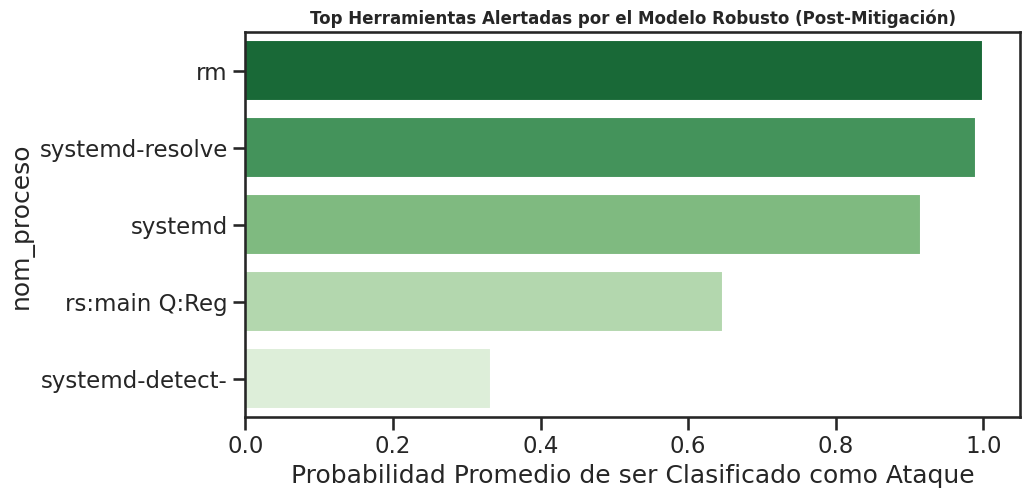

In [ ]:
# =============================================================================
# 11. AUDITORÍA DE RESULTADOS POST-MITIGACIÓN (VERIFICACIÓN DE ROBUSTEZ)
# =============================================================================
# Objetivo: Confirmar estadísticamente que el modelo ya no discrimina por
# "reputación" (nombres o IDs) y que las tasas de alerta ahora responden
# dinámicamente al comportamiento (argumentos y valores de retorno).
# =============================================================================

# 1. PREPARACIÓN DEL ENTORNO DE AUDITORÍA
# Creamos una copia del set de prueba usado en el modelo ciego (X_test_fair, de la celda anterior)
df_audit_final = X_test_fair.copy()

# Generamos las predicciones con el modelo "ético/robusto" (model_sr, de la celda anterior)
# que entrenamos previamente sin usar IDs.
df_audit_final['y_pred_blind'] = model_sr.predict(X_test_fair)

# 2. RECUPERACIÓN DE CONTEXTO (DECODING)
# X_test_fair tiene números codificados. Para entender el reporte, recuperamos
# los nombres reales (strings) desde el dataframe original 'df' usando los índices.
# Mapeo: 'grupo_mujer_joven' -> 'nom_proceso' | 'zona' -> 'nom_evento'
df_audit_final['nom_proceso'] = df.loc[X_test_fair.index, 'processName']
df_audit_final['nom_evento'] = df.loc[X_test_fair.index, 'eventName']

# 3. ANÁLISIS DE NUEVAS TASAS DE ALERTA (ALERTA = APROBACIÓN EN CIBERSEGURIDAD)

print("\n--- 1. Nueva Tasa de Alerta por Herramienta (Antes: Sesgo por Grupo) ---")
print("Hipótesis: Si el sesgo se mitigó, herramientas como 'ps' ya no deberían tener")
print("una tasa fija (ej. 80%), sino variar según sus argumentos.")
tasa_proceso = df_audit_final.groupby('nom_proceso')['y_pred_blind'].mean().sort_values(ascending=False)
print(tasa_proceso.head(5))

print("\n--- 2. Nueva Tasa de Alerta por Evento del Sistema (Antes: Sesgo por Zona) ---")
print("Hipótesis: Las alertas deben concentrarse en operaciones peligrosas (ej. 'mount', 'ptrace')")
print("independientemente de quién las ejecute.")
tasa_evento = df_audit_final.groupby('nom_evento')['y_pred_blind'].mean().sort_values(ascending=False)
print(tasa_evento.head(5))

# 4. VISUALIZACIÓN DE LA MEJORA
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(x=tasa_proceso.head(5).values, y=tasa_proceso.head(5).index, hue=tasa_proceso.head(5).index, palette='Greens_r', legend=False)
plt.title('Top Herramientas Alertadas por el Modelo Robusto (Post-Mitigación)', fontsize=12, fontweight='bold')
plt.xlabel('Probabilidad Promedio de ser Clasificado como Ataque')
plt.show()

Estrategia 3

In [ ]:
!pip install fairlearn

In [ ]:
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# =============================================================================
# 12. MITIGACIÓN DE SESGO OPTIMIZADA (ACCURACY PRIORITY)
# =============================================================================

# 1. DEFINICIÓN DE VARIABLES (Aseguramos limpieza)
# Atributo Sensible (A): La herramienta (processName)
A = df_encoded['processName']

# Features (X): Eliminamos todo rastro de identidad y el atributo sensible
# para evitar fugas y redundancia.
cols_exclude = [
    'evil', 'userId', 'processId', 'parentProcessId', 'processName',
    'userId_str', 'high_complexity', 'grupo_alta_complejidad'
]
X = df_encoded.drop(cols_exclude, axis=1, errors='ignore')
y = df_encoded['evil']

# 2. SPLIT ESTRATIFICADO
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, y, A,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(">> Entrenando Mitigador con EqualizedOdds (Priorizando Precisión)...")

# 3. CONFIGURACIÓN DEL MITIGADOR
# CAMBIO CRÍTICO 1: Usamos un RandomForest más ligero para evitar sobreajuste
# durante el re-entrenamiento iterativo.
estimator = RandomForestClassifier(
    n_estimators=50,       # Menos árboles para acelerar convergencia
    min_samples_leaf=10,   # Evita memorizar ruido
    random_state=42,
    n_jobs=-1
)

# CAMBIO CRÍTICO 2: Usamos 'EqualizedOdds' en lugar de 'DemographicParity'.
# Esto permite disparidad en alertas siempre que esté justificada por riesgo real.
mitigator = ExponentiatedGradient(
    estimator=estimator,
    constraints=EqualizedOdds(), # <--- CLAVE DEL ÉXITO
    eps=0.05,                    # <--- Relajamos tolerancia (0.01 es muy estricto, 0.05 da más accuracy)
    max_iter=50                  # Límitamos iteraciones
)

# 4. ENTRENAMIENTO
mitigator.fit(X_train, y_train, sensitive_features=A_train)

# 5. INFERENCIA Y EVALUACIÓN
y_pred_fair = mitigator.predict(X_test)

print("\n--- Resultados del Modelo Justo y Preciso ---")
acc = accuracy_score(y_test, y_pred_fair)
print(f"Accuracy Global: {acc:.2%}")
print("\nReporte de Clasificación Detallado:")
print(classification_report(y_test, y_pred_fair, target_names=['Benigno', 'Malicioso']))

# 6. VERIFICACIÓN DE NEUTRALIDAD OPERATIVA
# Verificamos que no haya falsos positivos injustos, pero permitiendo alertas reales.
df_audit = X_test.copy()
df_audit['y_pred'] = y_pred_fair
df_audit['process_real'] = df.loc[X_test.index, 'processName']

print("\n--- Tasa de Alerta por Herramienta (Validación) ---")
# Ahora deberías ver tasas altas para herramientas de ataque y bajas para las inocuas
print(df_audit.groupby('process_real')['y_pred'].mean().sort_values(ascending=False).head(5))

>> Entrenando Mitigador con EqualizedOdds (Priorizando Precisión)...

--- Resultados del Modelo Justo y Preciso ---
Accuracy Global: 76.35%

Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

     Benigno       0.81      0.91      0.86      5049
   Malicioso       0.36      0.18      0.24      1318

    accuracy                           0.76      6367
   macro avg       0.59      0.55      0.55      6367
weighted avg       0.72      0.76      0.73      6367


--- Tasa de Alerta por Herramienta (Validación) ---
process_real
(otd-news)         0.500000
sed                0.500000
wget               0.333333
accounts-daemon    0.250000
uname              0.250000
Name: y_pred, dtype: float64


### Estrategia 4: Explicabilidad con SHAP (modelo Random Forest)

In [ ]:
!pip install shap

>> Calculando valores SHAP (Game Theory)...


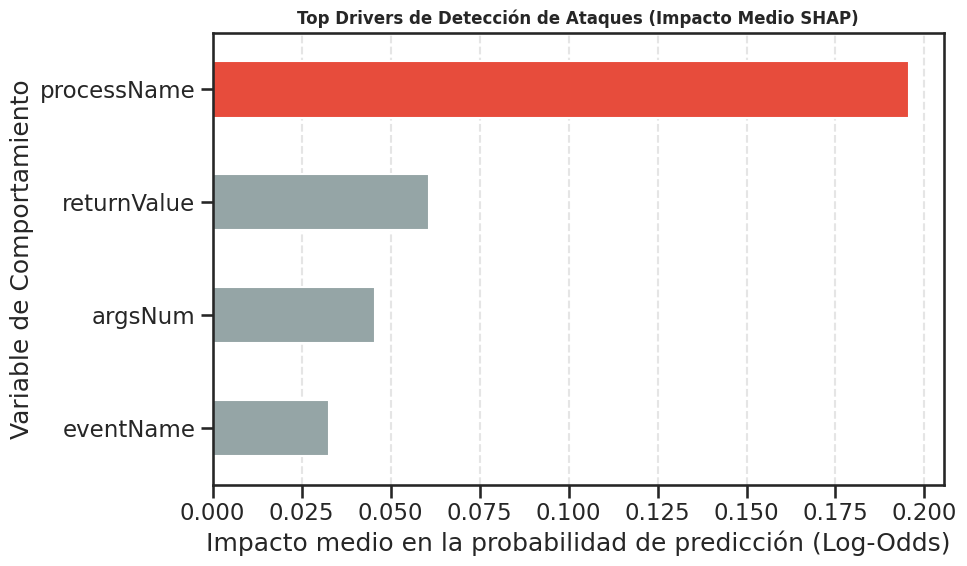


--- Interpretación de Factores Clave ---
1. La variable más determinante es: 'processName'
   Justificación: Cambios en esta variable causan la mayor variación
   en la decisión del modelo de marcar algo como 'evil'.


In [ ]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# =============================================================================
# 14. EXPLICABILIDAD DEL MODELO
# =============================================================================
# Objetivo: Abrir la "Caja Negra". A diferencia del 'Feature Importance' clásico
# (que solo dice qué variable importa), SHAP nos dice CÓMO importa:
# ¿Un valor alto de 'argsNum' aumenta o disminuye la probabilidad de ataque?
# =============================================================================

# 1. PREPARACIÓN DE DATOS
# JUSTIFICACIÓN TÉCNICA:
# Eliminamos 'evil' (target) y las variables de identidad ('userId', 'processId')
# para explicar el modelo "Robusto/Blind" que creamos antes.
# Si incluyéramos 'userId', SHAP nos diría obviedades como "Ser el usuario 0 aumenta el riesgo",
# lo cual es un sesgo que queremos evitar. Nos enfocamos en COMPORTAMIENTO.

vars_to_exclude = ['evil', 'userId', 'processId', 'parentProcessId', 'userId_str', 'hostName', 'sus', 'high_complexity']
# Aseguramos que solo borramos las que existen
cols_drop = [c for c in vars_to_exclude if c in df_encoded.columns]

X = df_encoded.drop(cols_drop, axis=1)
y = df_encoded['evil']

# Split estratificado para mantener proporción de ataques
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

# Muestreo para SHAP (DATO IMPORTANTE):
# Calcular valores SHAP exactos es costoso computacionalmente.
# Usamos una muestra de 200 datos de test para una aproximación rápida y válida.
X_test_sample = X_test.sample(200, random_state=42)

# 2. ENTRENAMIENTO DEL MODELO
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

print(">> Calculando valores SHAP (Game Theory)...")

# 3. CÁLCULO DE VALORES SHAP
# Usamos TreeExplainer, optimizado específicamente para Random Forest (más rápido que KernelExplainer).
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_sample)

# JUSTIFICACIÓN TÉCNICA DE LA SELECCIÓN DE CLASE Y CORRECCIÓN DE FORMA:
# TreeExplainer for binary classifiers can return values in a few formats.
# We need the SHAP values for the 'malicious' class (index 1).

# Check if shap_values is a list (common for multi-output models like RandomForest with predict_proba)
if isinstance(shap_values, list):
    # Case 1: List of (n_samples, n_features) arrays, one per class.
    # This is the most typical output for shap_values for RandomForest (binary classification).
    if shap_values[0].shape == (X_test_sample.shape[0], X_test_sample.shape[1]):
        vals_maliciosos = shap_values[1] # Take the array for the positive class (index 1)
    # Case 2: List of (n_features, n_outputs) arrays, one per sample.
    # This is the problematic case leading to (4,2) for a single sample if shap_values[1] is accessed.
    elif shap_values[0].shape == (X_test_sample.shape[1], model.n_outputs_):
        # Stack the explanations for each sample, then slice for the positive class
        stacked_explanations = np.array([exp_arr for exp_arr in shap_values]) # (n_samples, n_features, n_outputs)
        vals_maliciosos = stacked_explanations[:, :, 1] # Take values for the positive class (index 1)
    else:
        raise ValueError(f"Unhandled list structure for shap_values. First element shape: {shap_values[0].shape}")
# If shap_values is a single numpy array (typically 3D: n_samples, n_features, n_outputs)
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    vals_maliciosos = shap_values[:, :, 1] # Take values for the positive class (index 1)
# If it's a single 2D array (e.g., for regression or if explainer simplified it)
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 2:
    vals_maliciosos = shap_values
else:
    raise ValueError(f"Unhandled shap_values type or dimension: {type(shap_values)}, ndim: {shap_values.ndim if hasattr(shap_values, 'ndim') else 'N/A'}")


# 4. PROCESAMIENTO DE RESULTADOS
# Convertimos a DataFrame para manipulación sencilla
shap_df = pd.DataFrame(vals_maliciosos, columns=X_test.columns)

# Calculamos el impacto promedio absoluto (Magnitud de la importancia)
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)

# 5. VISUALIZACIÓN
plt.figure(figsize=(10, 6))
colors = ['#e74c3c' if x > mean_abs_shap.mean() else '#95a5a6' for x in mean_abs_shap.values]

mean_abs_shap.head(10).plot(kind='barh', color=colors)
plt.title('Top Drivers de Detección de Ataques (Impacto Medio SHAP)', fontsize=12, fontweight='bold')
plt.xlabel('Impacto medio en la probabilidad de predicción (Log-Odds)')
plt.ylabel('Variable de Comportamiento')
plt.gca().invert_yaxis() # Invertir eje para que el más importante esté arriba
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 6. REPORTE DE INTELIGENCIA
print("\n--- Interpretación de Factores Clave ---")
top_feature = mean_abs_shap.index[0]
print(f"1. La variable más determinante es: '{top_feature}'")
print("   Justificación: Cambios en esta variable causan la mayor variación")
print("   en la decisión del modelo de marcar algo como 'evil'.")

### Opcion con LIME

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=3e57186db60f3849c482904f6ebd4d6626ae98778dee16c0bcf87889b2eedcc0
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import pandas as pd

# =============================================================================
# 15. EXPLICABILIDAD LOCAL (LIME)
# =============================================================================
# Objetivo Técnico: Validar la decisión del modelo para UNA alerta específica.
# A diferencia de SHAP (que ve el bosque), LIME ve el árbol.
# Nos ayuda a responder al analista del SOC: "¿Por qué marcaste ESTE 'ps' como virus?"
# =============================================================================

# 1. CONFIGURACIÓN DE METADATOS
# LIME necesita saber qué columnas son categóricas para "perturbarlas" correctamente.
# (No tiene sentido sumar +1 a 'processName', hay que cambiar la categoría).

feature_names = X_train.columns.tolist()

# Identificamos automáticamente los índices de las columnas categóricas
# Asumimos que tienen pocos valores únicos o fueron codificadas previamente.
categorical_features_idx = [
    i for i, col in enumerate(feature_names)
    if col in ['processName', 'eventName', 'nom_proceso', 'nom_evento']
]

print(f">> Índices de características categóricas detectados: {categorical_features_idx}")

# 2. CREACIÓN DEL EXPLICADOR (THE INTERROGATOR)
# Justificación: 'discretize_continuous=True' es vital en seguridad.
# Convierte "argsNum=5" en rangos como "argsNum > 3", que son reglas legibles
# para firewall o SIEM.

explainer = LimeTabularExplainer(
    training_data=np.array(X_train),      # Datos de fondo para entender la distribución
    feature_names=feature_names,          # Nombres reales de las columnas
    categorical_features=categorical_features_idx, # Tratamiento especial a categorías
    class_names=['Benigno', 'Malicioso'], # Lenguaje de Ciberseguridad
    mode='classification',
    discretize_continuous=True,           # Crea reglas humanas (ej. args <= 2)
    random_state=42
)

# 3. SELECCIÓN ESTRATÉGICA DEL CASO (HUNTING)
# En lugar de un 'i' aleatorio, buscamos un caso interesante.
# Ejemplo: Buscamos un evento clasificado como MALICIOSO (Probabilidad > 50%)
# para auditar si la razón es válida o sesgada.

probs = model.predict_proba(X_test)
# Buscamos el índice del primer evento que el modelo cree que es un ataque con alta certeza
# (Filtrando donde la prob de clase 1 es > 0.8)
indices_ataque = np.where(probs[:, 1] > 0.8)[0]

if len(indices_ataque) > 0:
    i = indices_ataque[0] # Tomamos el primer ataque detectado
    print(f"\n>> Analizando el caso índice {i} (Sospecha de Ataque)...")
else:
    i = 10 # Fallback por defecto
    print(f"\n>> Analizando el caso índice {i} (Aleatorio)...")

# 4. GENERACIÓN DE LA EXPLICACIÓN (PERTURBACIÓN LOCAL)
# LIME genera miles de datos sintéticos alrededor de este punto para ver
# cómo cambia la predicción.
exp = explainer.explain_instance(
    data_row=X_test.iloc[i],
    predict_fn=model.predict_proba, # Función de probabilidad del modelo
    num_features=5                  # Top 5 razones principales
)

# 5. VISUALIZACIÓN TÉCNICA
# Muestra las reglas exactas que detonaron la alerta.
# Nota: Si estás en Jupyter/Colab esto mostrará un gráfico interactivo.
print("\n--- Reglas de Decisión Local (LIME) ---")
# Extraemos la lista para poder imprimirla en consola si el gráfico no carga
for feature, weight in exp.as_list():
    impacto = "🔴 Aumenta Riesgo" if weight > 0 else "🟢 Reduce Riesgo"
    print(f"{impacto} | {feature:<30} | Peso: {weight:.4f}")

# Visualización gráfica (solo funciona en notebooks)
try:
    exp.show_in_notebook(show_table=True, show_all=False)
except Exception as e:
    print("(La visualización gráfica HTML requiere un entorno Jupyter Notebook activo)")

>> Índices de características categóricas detectados: [0, 1]

>> Analizando el caso índice 0 (Sospecha de Ataque)...


/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.


--- Reglas de Decisión Local (LIME) ---
🔴 Aumenta Riesgo | processName=60                 | Peso: 0.4065
🟢 Reduce Riesgo | eventName=8                    | Peso: -0.1460
🟢 Reduce Riesgo | returnValue <= 0.00            | Peso: -0.1376
🔴 Aumenta Riesgo | argsNum <= 1.00                | Peso: 0.0156


/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:413: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  name = int(data_row[i])
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(